In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import os

In [2]:
tf.set_random_seed(777)

In [3]:
if "DISPLAY" not in os.environ:
    # remove Travis CI Error
    matplotlib.use('Agg')

In [4]:
import matplotlib.pyplot as plt

In [5]:
def MinMaxScalar(data):
    ''' Min Max Normalization
    References
    [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html'''

    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

In [6]:
#Train Parameter
seq_length = 7
data_dim = 5
hidden_dim = 10 
output_dim = 1
learning_rate = 0.01
iterations = 500

In [7]:
# Open, High, Low, Volume, Close
xy = np.loadtxt('data-02-stock_daily.csv', delimiter=',')
xy = xy[::-1] # reverse order (chronically ordered)
xy = MinMaxScalar(xy)
x = xy
y = xy[:, [-1]] # Close as label

In [8]:
#Bulid a dataset
dataX = []
dataY = []
for i in range (0,len(y) - seq_length):
    _x = x[i:i + seq_length]
    _y = y[i + seq_length] #Next close price
    #print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)

In [9]:
#train/test split
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:len(dataY)])

In [10]:
#input placeholder
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None,1]) 

In [11]:
#build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(num_units = hidden_dim, state_is_tuple = True, activation = tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn = None) #We use the last cell's output

In [12]:
#loss function
loss = tf.reduce_sum(tf.square(Y_pred - Y)) #sum of the squares
                     
#optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

In [13]:
#RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

RMSE: 0.027509834617376328


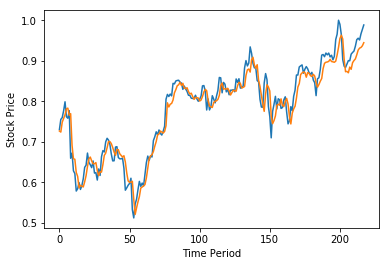

In [14]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    #Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict ={
            X: trainX, Y: trainY
        })
    
    #Test step
    test_predict = sess.run(Y_pred, feed_dict = {X: testX})
    rmse_val = sess.run(rmse, feed_dict ={
        targets: testY, predictions : test_predict
    })
    print("RMSE: {}".format(rmse_val))
    
    #Plot predictions
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()